In [2]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from qiskit import *
from qiskit import Aer
import qiskit.quantum_info as qi
import numpy as np
import matplotlib.pyplot as plt
import re

In [39]:
## Number of qubits.
N = 3

In [40]:
## The function opens the text file and returns the gates in columns. 
def Gate_List():
    
    with open('gates_list.txt', 'r') as file:
        rows = [[str(x) for x in line.split(',')[:-1]] for line in file]
        cols = [list(col) for col in zip(*rows)]
        
    return cols

In [41]:
## The following loop recreates the initial list structure of the list containing the gates.
## It also counts the total number of Rz gates in the list.
l = []
Rz_Number = 0

Number_of_gates = len(Gate_List()[0])

for i in range(Number_of_gates):
    
    if Gate_List()[0][i] == 'rz':
        
        angle = Gate_List()[1][i]
        qubit = Gate_List()[2][i]
        l.append(['rz', angle, qubit])
        
        Rz_Number = Rz_Number + 1
        
    elif Gate_List()[0][i] == 'cx':
        
        target = Gate_List()[1][i]
        control = Gate_List()[2][i]
        l.append(['cx', target, control])
        
    else:
        
        qubit = Gate_List()[2][i]
        l.append(['h',0.0, qubit])

In [4]:
#np.log(-1)

## Hadamard Gate
Given the qubit, the following function returns the matrix of the Hadamard gate for N qubits.

In [45]:
## The dimension of the matrix is fixed by the number of qubits.
def Hadamard(Qubit):
    
    ## Changing the simulator 
    backend = Aer.get_backend('unitary_simulator')

    ## The circuit without measurement
    circ = QuantumCircuit(N)
    circ.h(Qubit)

    ## job execution and getting the result as an object
    job = execute(circ, backend)
    result = job.result()

    ## get the unitary matrix from the result object
    return result.get_unitary(circ)

## CNOT Gate
Given the target and the control bit as input, the following function returns the matrix of the CNOT gate for N qubits.

In [46]:
## The dimension of the matrix is fixed by the number of qubits.
def C_not(t,c):
    ## Changing the simulator 
    backend = Aer.get_backend('unitary_simulator')

    ## The circuit without measurement
    circ = QuantumCircuit(N)
    circ.cx(t,c)

    ## job execution and getting the result as an object
    job = execute(circ, backend)
    result = job.result()

    ## get the unitary matrix from the result object
    return result.get_unitary(circ) 

## Rz Gate
Given the angle and the qubit it is applied to, the following function returns the matrix of the Rz gate for N qubits.

In [47]:
def Rz(Angle, Qubit):
    ## Changing the simulator 
    backend = Aer.get_backend('unitary_simulator')

    ## The circuit without measurement
    circ = QuantumCircuit(N)
    circ.rz(Angle, Qubit)

    ## job execution and getting the result as an object
    job = execute(circ, backend)
    result = job.result()

    ## get the unitary matrix from the result object
    return result.get_unitary(circ)     

## Diagnonalization of G, $G = V e^{-i \phi_F} V^{\dagger}$

In [ ]:
import numpy
import numpy.linalg

sigma_x=numpy.zeros((2,2),dtype=complex)
sigma_y=numpy.zeros((2,2),dtype=complex)
sigma_z=numpy.zeros((2,2),dtype=complex)
sigma_0=numpy.identity(2,dtype=complex)
sigma_x[0,1]=1.
sigma_x[1,0]=1.
sigma_y[0,1]=-1.j
sigma_y[1,0]=1.j
sigma_z[0,0]=1.
sigma_z[1,1]=-1.
sigma_plus=(sigma_x+1.j*sigma_y)/2.
sigma_minus=(sigma_x-1.j*sigma_y)/2.

def adjoint(psi):
    return psi.conjugate().transpose()

def psi_to_rho(psi):
    return numpy.outer(psi,psi.conjugate())

def exp_val(psi, op):
    return numpy.real(numpy.dot(adjoint(psi),op.dot(psi)))

def norm_sq(psi):
    return numpy.real(numpy.dot(adjoint(psi),psi))

def normalize(psi,tol=1e-9):
    ns=norm_sq(psi)**0.5
    if ns < tol:
        raise ValueError
    return psi/ns

def comm(a,b):
    return a.dot(b)-b.dot(a)

def anti_comm(a,b):
    return a.dot(b)+b.dot(a)

def is_herm(M,tol=1e-9):
    if M.shape[0]!=M.shape[1]:
        return False
    diff=M-adjoint(M)
    return max(numpy.abs(diff.flatten())) < tol

def is_unitary(M,tol=1e-9):
    if M.shape[0]!=M.shape[1]:
        return False
    diff=M.dot(adjoint(M))-numpy.identity((M.shape[0]))
    return max(numpy.abs(diff.flatten())) < tol

def eigu(U,tol=1e-9):
    (E_1,V_1)=numpy.linalg.eigh(U+adjoint(U))
    U_1=adjoint(V_1).dot(U).dot(V_1)
    H_1=adjoint(V_1).dot(U+adjoint(U)).dot(V_1)
    non_diag_lst=[]
    j=0
    while j < U_1.shape[0]:
        k=0
        while k < U_1.shape[0]:
            if j!=k and abs(U_1[j,k]) > tol:
                if j not in non_diag_lst:
                    non_diag_lst.append(j)
                if k not in non_diag_lst:
                    non_diag_lst.append(k)
            k+=1
        j+=1
    if len(non_diag_lst) > 0:
        non_diag_lst=numpy.sort(numpy.array(non_diag_lst))
        U_1_cut=U_1[non_diag_lst,:][:,non_diag_lst]
        (E_2_cut,V_2_cut)=numpy.linalg.eigh(1.j*(U_1_cut-adjoint(U_1_cut)))
        V_2=numpy.identity((U.shape[0]),dtype=V_2_cut.dtype)
        for j in range(len(non_diag_lst)):
            V_2[non_diag_lst[j],non_diag_lst]=V_2_cut[j,:]
        V_1=V_1.dot(V_2)
        U_1=adjoint(V_2).dot(U_1).dot(V_2)

    # Sort by phase
    U_1=numpy.diag(U_1)
    inds=numpy.argsort(numpy.imag(numpy.log(U_1)))

    return (U_1[inds],V_1[:,inds]) # = (U_d,V) s.t. U=V*U_d*V^\dagger

## $\phi_F$ from $U_d$
$V e^{-i \phi_F} V^{\dagger} = V U_d V^{\dagger}$, so, $e^{-i \phi_F} = U_d$. Given $U_d$ by the function eigu, this function returns the array $\phi_F$.

In [48]:
## exp(-i*phi_F) = U_d. Given U_d by the function eigu, this function returns the array phi_F.
def Phi_F(Vector):
    
    phi_F = np.zeros(2**N, dtype = complex)
    
    for i in range(2**N):
        
        if abs(1-Vector[i]) < 1.e-6:
            
            phi_F[i] = -2*np.pi
            
        elif Vector[i].real < 0:
            
            phi_F[i] = 1j*np.log(abs(Vector[i])) - np.pi
            
        else:
            
            phi_F[i] = 1j*np.log(Vector[i])
            
    return phi_F

# Grover with noise.

## Noise creation
This following line creates an array of random numbers which length is equal to the number of Rz gates.

In [57]:
Rz_Noise = np.random.rand(Rz_Number)

# Use the line below for no noise case.
#Rz_Noise = np.zeros(Rz_Number)

In [49]:
## Given the noise strength epsilon, this function returns the array phi_F for G = V * exp(-i*phi_F) * V^\dagger

def Phi(epsilon):
    
    ## Initializing the Grover operator as an identity matrix.
    Gr = np.identity(2**N, dtype = complex) 

    ## In the following loop we multiply all the 1 and 2 qubit gates with noise.
    j = 0
    for i in range(len(l)):
    
        if l[i][0] == 'rz':
        
            Gr = np.matmul(Rz(float(l[i][1]) + epsilon * Rz_Noise[j] , int(l[i][2])) ,Gr)
            j = j + 1
        
        elif l[i][0] == 'h':
        
            Gr = np.matmul(Hadamard(int(l[i][2])), Gr)
        
        else:
        
            Gr = np.matmul(C_not(int(l[i][1]), int(l[i][2])), Gr)
        
    return Phi_F(eigu(Gr)[0]).real  #eigu(Gr)[0] = exp(-i * phi_F).

In [50]:
f = open('quantum_data.txt', 'w')
for i in range(1,50):
    eps = i/25
    f = open('quantum_data.txt', 'a')
    for j in range(2**N):
        f.write(str(eps)+','+str(Phi(eps)[j])+'\n')
    f.close()    

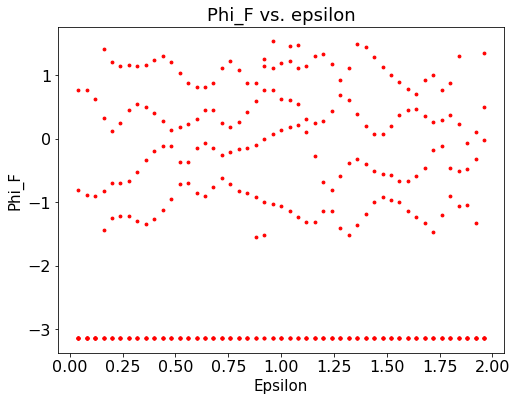

In [1]:
import matplotlib.pyplot as plt
import numpy as np

X, Y = np.loadtxt('quantum_data.txt', delimiter = ',', unpack=True)
f = plt.figure()
f.set_figwidth(8)
f.set_figheight(6)
plt.scatter(X, Y, s=8, c='r')

plt.title('Phi_F vs. epsilon',fontsize=18)
plt.xlabel('Epsilon',fontsize=15)
plt.xticks(fontsize=16)
plt.ylabel('Phi_F',fontsize=15)
plt.yticks(fontsize=16)
plt.show()

